In [66]:
import numpy as np
import yfinance as yf
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM, Dense

import matplotlib.pyplot as plt

from datetime import datetime, timedelta

# stocks to visualize and forecast
stock = 'GOOGL'

# fetch stock data for previous year
stockData = yf.download(tickers=stock, start = datetime.now() - timedelta(years=10), end = datetime.now())
stockData.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-11-15,98.260002,100.139999,96.709999,98.440002,98.440002,41640800
2022-11-16,97.900002,99.639999,97.639999,98.849998,98.849998,29105200
2022-11-17,96.970001,99.279999,96.790001,98.360001,98.360001,26052600
2022-11-18,98.769997,98.900002,96.370003,97.430000,97.430000,28342300
2022-11-21,97.290001,98.400002,95.360001,95.599998,95.599998,21647400


Visualize Stock

Text(0, 0.5, 'Prices ($)')

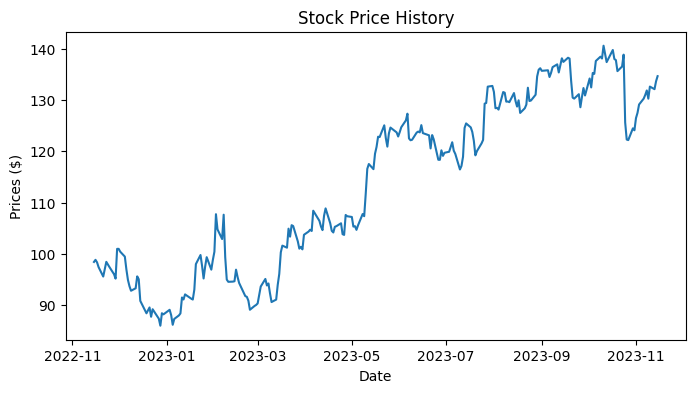

In [67]:
plt.figure(figsize=(8, 4))
plt.title('Stock Price History')
plt.plot(stockData['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

forecast stock price

In [68]:
# extract stock prices
closePrices = stockData['Close'].values.reshape(-1, 1)

# normalize dataset
scaler = MinMaxScaler(feature_range=(0, 1))
normalizedPrices = scaler.fit_transform(closePrices)

In [69]:
# split into training and test sets
trainSize = int(0.67 * len(normalizedPrices))

train, test = normalizedPrices[0: trainSize, : ], normalizedPrices[trainSize: len(normalizedPrices),:]
print(len(train), len(test))

168 84


In [70]:
# convert an array of values into a dataset matrix
def createDataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [71]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = createDataset(train, look_back)
testX, testY = createDataset(test, look_back)

In [72]:
# reshape input
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [73]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
166/166 - 3s - loss: 0.1578 - 3s/epoch - 16ms/step
Epoch 2/100
166/166 - 1s - loss: 0.0735 - 527ms/epoch - 3ms/step
Epoch 3/100
166/166 - 1s - loss: 0.0487 - 705ms/epoch - 4ms/step
Epoch 4/100
166/166 - 0s - loss: 0.0419 - 412ms/epoch - 2ms/step
Epoch 5/100
166/166 - 0s - loss: 0.0366 - 363ms/epoch - 2ms/step
Epoch 6/100
166/166 - 0s - loss: 0.0316 - 354ms/epoch - 2ms/step
Epoch 7/100
166/166 - 0s - loss: 0.0268 - 323ms/epoch - 2ms/step
Epoch 8/100
166/166 - 0s - loss: 0.0223 - 304ms/epoch - 2ms/step
Epoch 9/100
166/166 - 0s - loss: 0.0178 - 273ms/epoch - 2ms/step
Epoch 10/100
166/166 - 0s - loss: 0.0136 - 261ms/epoch - 2ms/step
Epoch 11/100
166/166 - 0s - loss: 0.0099 - 246ms/epoch - 1ms/step
Epoch 12/100
166/166 - 0s - loss: 0.0071 - 245ms/epoch - 1ms/step
Epoch 13/100
166/166 - 1s - loss: 0.0049 - 506ms/epoch - 3ms/step
Epoch 14/100
166/166 - 0s - loss: 0.0033 - 472ms/epoch - 3ms/step
Epoch 15/100
166/166 - 0s - loss: 0.0024 - 419ms/epoch - 3ms/step
Epoch 16/100
166/166 

In [74]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# untransform predictions
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

3/3 [==============================] - 0s 2ms/step


Visualize Predictions

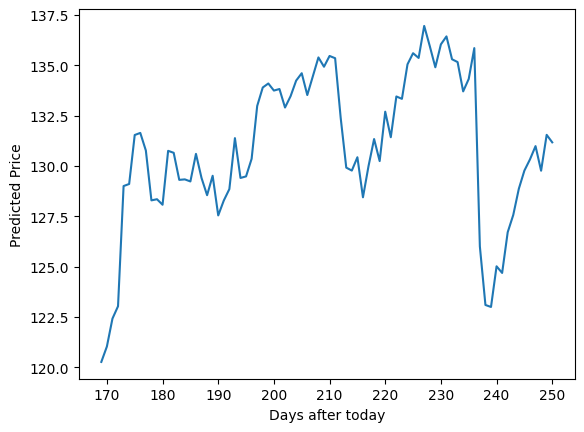

In [75]:
testPredictPlot = np.empty_like(closePrices)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(closePrices) - 1, :] = testPredict

plotName = stock + " prediction"

plt.plot(testPredictPlot, label='Predictions')

plt.xlabel('Days after today')
plt.ylabel('Predicted Price')

plt.show()